# Introduction

Can I build a collocation fitting code with sympy?

In [89]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [90]:
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({'font.size':16})

<Figure size 432x288 with 0 Axes>

# gen test data

In [91]:
X_all = np.linspace(-2, 2, 100)
y_all = 2 * X_all**2 - 1*X_all**3

In [92]:
np.random.randint(0, len(X_all), 5)

array([51, 79, 85, 56, 38])

In [93]:
X = X_all[[5, 50, 75]]
y = y_all[[5, 50, 75]]

# rand_idx=np.random.randint(0, len(X_all), 5)

# X = X_all[rand_idx]
# y = y_all[rand_idx]

In [94]:
iX = IUS(X_all, y_all)

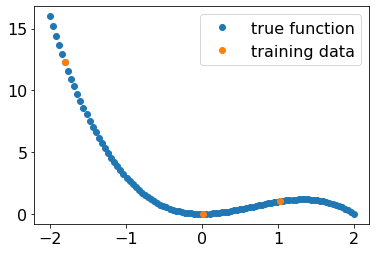

In [95]:
plt.plot(X_all, y_all, 'o', label='true function')
plt.plot(X, y, 'o', label='training data')
plt.legend()

In [96]:
X_all[-1]

In [97]:
y_all[-1]

# dev class

In [98]:
import sympy
sympy.init_printing()
x_sym, a_sym = sympy.symbols('x_sym a_sym')

In [99]:
ansatz = 2*x_sym**0 + x_sym**2 + 5*x_sym**3*a_sym

In [100]:
ansatz

In [101]:
ansatz.as_coefficients_dict()

In [102]:
ansatz.as_coefficients_dict()[x_sym**2]

In [103]:
ansatz.as_coefficients_dict()[a_sym*x_sym**3]

In [104]:
ansatz.as_coefficients_dict().keys()

dict_keys([1, x_sym**2, a_sym*x_sym**3])

In [105]:
ansatz.args[1].subs({'x_sym':2.5*a_sym})

In [106]:
# ansatz = x_sym**0 + x_sym**2 + x_sym**3
# ansatz = x_sym**0

In [107]:
# ansatz

In [108]:
# ansatz.subs({'x_sym':1})

In [109]:
# term by term differentiation
[term for term in ansatz.args]

In [110]:
[sympy.diff(term, x_sym, 0) for term in ansatz.args]

In [111]:
[sympy.diff(term, x_sym, 1) for term in ansatz.args]

In [112]:
[sympy.diff(term, x_sym, 2) for term in ansatz.args]

In [113]:
[sympy.diff(term, x_sym, 3) for term in ansatz.args]

In [114]:
class CollocationModel(object):
    def __init__(self, collocation_points, rhs, ansatz):
        """
        collocation_points: a list of lists
            [[d0], [d1], [d2], ...]
            d0 == points to evaluate RHS at zeroth derivative
            d1 == points to evaluate RHS at 1st derivative
            d2 == points to evaluate RHS at 2nd derivative ...etc
            The sum total of elments of the flattened list is the
            number of equations and equivalently the number of
            coefficients to fix by comparing with data.
            Data is provided as the right hand side (RHS).
        rhs: right hand side (rhs)
            provided in the same format as collocation_points
        ansatz: sympy stuff
            this must be a linear-in-coefficients ansatz so that
            it can be expressed in a matrix form
        """
        self.collocation_points = collocation_points
        self.rhs = rhs
        
        # flatten collocation points
        # collocation_points = []
        # [collocation_points.extend(r) for r in self.collocation_points]
        # self.collocation_points_1d = np.array(collocation_points, dtype=np.float64)
        self.collocation_points_1d = np.concatenate(self.collocation_points)
        
        # flatten right hand side
        # rhs = []
        # [rhs.extend(r) for r in self.rhs]
        # self.rhs_1d = np.array(rhs, dtype=np.float64)
        self.rhs_1d = np.concatenate(self.rhs)
        
        assert len(self.collocation_points_1d) == len(self.rhs_1d), "number of collocation points and rhs are not the same"
        
        # set degrees of freedom
        self.dof = len(self.collocation_points_1d)
        
        self.ansatz = ansatz
        
        assert self.dof == len(self.ansatz.args), f"ansatz doesn't contain correct number of degrees of freedom. dof = {self.dof}. Ansatz has {len(self.ansatz.args)}"
        
    def lambdify_ansatz(self, sympy_args):
        # terms_fn: list of sympy.lambdify functions
        # each element of the list corresponds to each term in the ansatz
        self.terms_fn = [sympy.lambdify(sympy_args, term, "numpy") for term in self.ansatz.args]
        
    def create_information_matrix(self):
        """
        evaluate the ansatz at the collocation_points
        """
        # compute information matrix


        # need to compute derivatives term by term
        # that way we can be sure that we arrive at the correct number of
        # elements in each row
        # and then we can correctly handle when a derivative is zero.
        row = []
        # just taking 0th element because this corresponds to the 0th derivative values
        for d in range(len(self.collocation_points)):
            for c in self.collocation_points[d]:
                terms = [sympy.diff(term, x_sym, d) for term in self.ansatz.args]
                row.append([term.subs({'x_sym':c}) for term in terms])
        information_matrix = np.array(row, dtype=np.float64)
        self.information_matrix = information_matrix
        
    def fit(self, information_matrix=None, rhs=None):
        if information_matrix == None:
            information_matrix = self.information_matrix
        if rhs == None:
            rhs = self.rhs_1d
        self.coeffs = np.linalg.solve(information_matrix, rhs)
        
    def get_basis(self, x):
        basis = np.array([t(x) for t in self.terms_fn], dtype=object)
        return basis
        
    def predict(self, x):
        basis = self.get_basis(x)
        return np.dot(self.coeffs, basis)

In [115]:
sympy.Poly(np.ones(5), x_sym)

In [116]:
ansatz = sympy.Poly(np.ones(8), x_sym).as_expr()
# ansatz = sympy.Poly(np.ones(3), x_sym).as_expr() + sympy.asinh(10*x_sym)**2

# ansatz = x_sym**0 + x_sym**2 + x_sym**3 + x_sym**4 + x_sym**5

# ansatz = x_sym**2 + sympy.asinh(x_sym) + sympy.asinh(x_sym)**2 + sympy.asinh(x_sym)**3 + sympy.asinh(x_sym)**4 + sympy.asinh(x_sym)**5 + sympy.asinh(x_sym)**6

# ansatz = 1 + x_sym + x_sym**2


In [117]:
len(ansatz.args)

In [118]:
ansatz.args

In [119]:
ansatz

In [120]:
collocation_points = {
    '0th':X,
    '1st':[X[0], X[2]],
    '2nd':[X[0], X[2]],
    '3rd':[X[0]],
}

rhs = {
    '0th':y,
    '1st':[iX.derivative()(X[0]), iX.derivative()(X[2])],
    '2nd':[iX.derivative(2)(X[0]), iX.derivative(2)(X[2])],
    '3rd':[iX.derivative(3)(X[0])],
}



In [121]:
cm = CollocationModel(
    collocation_points=[
        collocation_points['0th'],
        collocation_points['1st'],
        collocation_points['2nd'],
        collocation_points['3rd'],
    ],
    rhs=[
        rhs['0th'],
        rhs['1st'],
        rhs['2nd'],
        rhs['3rd'],
    ],
    ansatz=ansatz)

In [122]:
cm.lambdify_ansatz(sympy_args=(x_sym))

In [123]:
cm.create_information_matrix()

In [124]:
cm.fit()

In [125]:
cm.coeffs

array([-5.23062521e-14,  2.63158634e-12,  2.00000000e+00, -1.00000000e+00,
        3.25555601e-12,  1.55309984e-12, -9.31845936e-13, -4.06882757e-13])

In [126]:
cm.predict(np.array([1,2,3]))

array([ 1.00000000e+00, -4.05225709e-11, -9.00000000e+00])

In [127]:
np.concatenate(cm.collocation_points)

array([-1.7979798 ,  0.02020202,  1.03030303, -1.7979798 ,  1.03030303,
       -1.7979798 ,  1.03030303, -1.7979798 ])

In [128]:
cm.create_information_matrix()

In [129]:
cm.rhs

[array([1.22778484e+01, 8.07998359e-04, 1.02935693e+00]),
 [array(-16.89011325), array(0.93663912)],
 [array(14.78787879), array(-2.18181818)],
 [array(-6.)]]

In [130]:
cm.ansatz

In [131]:
sympy.diff(cm.ansatz, x_sym, 0)

In [132]:
sympy.diff(cm.ansatz, x_sym, 1)

In [133]:
cm.information_matrix.shape

In [134]:
# row

In [135]:
# compute information matrix


# need to compute derivatives term by term
# that way we can be sure that we arrive at the correct number of
# elements in each row
# and then we can correctly handle when a derivative is zero.
row = []
# just taking 0th element because this corresponds to the 0th derivative values
for d in range(len(cm.collocation_points)):
    for c in cm.collocation_points[d]:
        terms = [sympy.diff(term, x_sym, d) for term in cm.ansatz.args]
        row.append([term.subs({'x_sym':c}) for term in terms])
information_matrix = np.array(row, dtype=np.float64)

In [136]:
np.testing.assert_array_equal(information_matrix, cm.information_matrix)

In [137]:
rhs = []
[rhs.extend(r) for r in cm.rhs]
rhs = np.array(rhs, dtype=np.float64)

In [138]:
rhs

array([ 1.22778484e+01,  8.07998359e-04,  1.02935693e+00, -1.68901133e+01,
        9.36639118e-01,  1.47878788e+01, -2.18181818e+00, -6.00000000e+00])

In [139]:
cm.information_matrix.shape

In [140]:
rhs.shape

In [141]:
# coeffs = np.linalg.solve(cm.information_matrix, rhs + np.random.normal(0, 0.01, size=rhs.shape))
coeffs = np.linalg.solve(cm.information_matrix, rhs)

In [142]:
coeffs

array([-5.23062521e-14,  2.63158634e-12,  2.00000000e+00, -1.00000000e+00,
        3.25555601e-12,  1.55309984e-12, -9.31845936e-13, -4.06882757e-13])

In [143]:
np.array(cm.ansatz.args)

array([1.00000000000000, 1.0*x_sym, 1.0*x_sym**2, 1.0*x_sym**3,
       1.0*x_sym**4, 1.0*x_sym**5, 1.0*x_sym**6, 1.0*x_sym**7],
      dtype=object)

In [144]:
""".subs({'x_sym':x})"""

".subs({'x_sym':x})"

In [145]:
terms_fn = [sympy.lambdify((x_sym), term, "numpy") for i, term in enumerate(cm.ansatz.args)]

In [146]:
type(terms[0])

sympy.core.numbers.Zero

In [147]:
terms_fn[0](np.array([0,2,3]))

In [148]:
X_all.shape

In [149]:
# note that because the first term
# is just a constant sympy
# will not broadcast the value
cm.ansatz.args[0]

In [150]:
# as shown here
terms_fn[0](np.array([1,2,3,4]))

In [151]:
# for the other terms it broadcasts
terms_fn[1](np.array([1,2,3,4]))

array([1., 2., 3., 4.])

In [152]:
# numpy does come to our rescue though because
# when we build our basis
# even though the basis
# is a ragged array
# when we np.dot the coefficients
# with it it all works out ok.

In [153]:
basis = np.array([t(X_all) for t in terms_fn], dtype=object)

In [154]:
yhat_new = np.dot(cm.coeffs, basis)

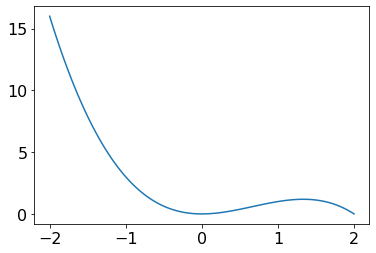

In [155]:
plt.plot(X_all, yhat_new)

In [156]:
# brute force way of creating prediction
yhat = [np.sum([coeffs[i] * term.subs({'x_sym':x}) for i, term in enumerate(cm.ansatz.args)]) for x in X_all]

In [157]:
yhat = np.array(yhat, dtype=np.float64)

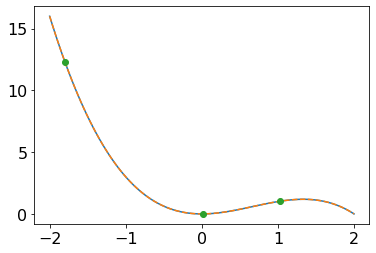

In [158]:
plt.plot(X_all, y_all)
plt.plot(X_all, yhat, ls='--')
plt.plot(X, y, 'o')

In [159]:
np.testing.assert_array_equal(yhat, yhat_new)

# using collocation.py module

In [160]:
import collocation as col

In [161]:
ansatz = sympy.Poly(np.ones(8), x_sym).as_expr()
# ansatz = sympy.Poly(np.ones(3), x_sym).as_expr() + sympy.asinh(10*x_sym)**2

# ansatz = x_sym**0 + x_sym**2 + x_sym**3 + x_sym**4 + x_sym**5

# ansatz = x_sym**2 + sympy.asinh(x_sym) + sympy.asinh(x_sym)**2 + sympy.asinh(x_sym)**3 + sympy.asinh(x_sym)**4 + sympy.asinh(x_sym)**5 + sympy.asinh(x_sym)**6

# ansatz = 1 + x_sym + x_sym**2


In [162]:
len(ansatz.args)

In [163]:
ansatz.args

In [164]:
ansatz

In [165]:
collocation_points = {
    '0th':X,
    '1st':[X[0], X[2]],
    '2nd':[X[0], X[2]],
    '3rd':[X[0]],
}

rhs = {
    '0th':y,
    '1st':[iX.derivative()(X[0]), iX.derivative()(X[2])],
    '2nd':[iX.derivative(2)(X[0]), iX.derivative(2)(X[2])],
    '3rd':[iX.derivative(3)(X[0])],
}



In [166]:
cm = col.CollocationModel(
    collocation_points=[
        collocation_points['0th'],
        collocation_points['1st'],
        collocation_points['2nd'],
        collocation_points['3rd'],
    ],
    rhs=[
        rhs['0th'],
        rhs['1st'],
        rhs['2nd'],
        rhs['3rd'],
    ],
    ansatz=ansatz)

In [167]:
cm.lambdify_ansatz(sympy_args=(x_sym))

In [168]:
cm.create_information_matrix()

In [169]:
cm.fit()

In [170]:
cm.coeffs

array([-5.23062521e-14,  2.63158634e-12,  2.00000000e+00, -1.00000000e+00,
        3.25555601e-12,  1.55309984e-12, -9.31845936e-13, -4.06882757e-13])

In [171]:
cm.predict(np.array([1,2,3]))

array([ 1.00000000e+00, -4.05225709e-11, -9.00000000e+00])

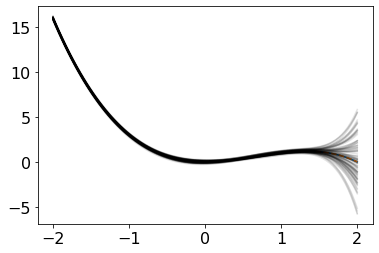

In [174]:
plt.plot(X_all, y_all)
plt.plot(X_all, cm.predict(X_all), ls='--')


# we can add uncertainty by adding noise to the coefficients



for i in range(100):
    cm.fit(rhs=(cm.rhs_1d + np.random.normal(0, 0.1, size=cm.rhs_1d.shape)))
    plt.plot(X_all, cm.predict(X_all), c='k', alpha=0.1)


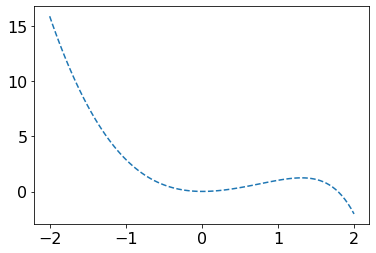

In [175]:
# note that the best fit coefficient have now been overwritten
plt.plot(X_all, cm.predict(X_all), ls='--')

In [176]:
# we can get them back by re-fitting
cm.fit()

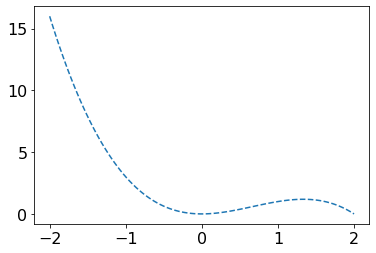

In [177]:
# note that the best fit coefficient have now been overwritten
plt.plot(X_all, cm.predict(X_all), ls='--')